In [ ]:
!pip install pandas
!pip install word2number

import pandas as pd
import re
from word2number import w2n


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/311/cleaned_data_combined_modified.csv')

# Display the first few rows of the DataFrame
df.head()



,id,"Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)",Q2: How many ingredients would you expect this food item to contain?,Q3: In what setting would you expect this food to be served? Please check all that apply,Q4: How much would you expect to pay for one serving of this food item?,Q5: What movie do you think of when thinking of this food item?,Q6: What drink would you pair with this food item?,"Q7: When you think about this food item, who does it remind you of?",Q8: How much hot sauce would you add to this food item?,Label
0,716549,3,6,"Week day lunch,At a party,Late night snack",5,Cloudy with a Chance of Meatballs,Coke,Friends,A little (mild),Pizza
1,715742,4,"bread, meet","Week day lunch,At a party,Late night snack",5$ for a large piece,All sort of american young boy movies,Coke,"Friends,Teachers,Strangers",NaN,Pizza
2,727333,3,5,"Week day lunch,Week day dinner,Weekend lunch,W...",10dollar,action movie,cola,Friends,A moderate amount (medium),Pizza
3,606874,4,6-7,"Week day lunch,Week day dinner,Weekend lunch,W...",$3,Mamma Mia,Soda,"Siblings,Friends,Teachers",I will have some of this food item with my hot...,Pizza
4,505318,2,3 or more,"Week day lunch,Week day dinner,Weekend lunch,W...",$5,Cloudy with a chance of meatballs,Soda,"Siblings,Friends",A little (mild),Pizza


How to parse "How many ingredients" Q2

*  take average
*  take first number
* take last number
* count how many spaces in between the words or commas



In [ ]:
# Define a dictionary to map month abbreviations to numbers
month_map = {
    'Jan': '1',
    'Feb': '2',
    'Mar': '3',
    'Apr': '4',
    'May': '5',
    'Jun': '6',
    'Jul': '7',
    'Aug': '8',
    'Sep': '9',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
}

# Function to convert date format
def convert_date_format(date_str):
    if isinstance(date_str, str) and '-' in date_str:
        try:
            day, month_abbr = date_str.split('-')
            month_num = month_map.get(month_abbr, month_abbr)
            return f"{int(month_num)}-{int(day)}"
        except ValueError:
           return date_str
    return date_str

# Apply the function to the Q2 column
df['Q2: How many ingredients would you expect this food item to contain?'] = df['Q2: How many ingredients would you expect this food item to contain?'].apply(convert_date_format)

# Function to take the average if there's a range(either with '-' or 'to')
def average_of_range(text):
  if isinstance(text, str):
    range_match = re.search(r'(\d+)[\s-]+(\d+)', text)
    range_match2 = re.search(r'(\d+)\s* to \s*(\d+)', text)

    if range_match is not None:
      num1, num2 = int(range_match.group(1)), int(range_match.group(2))
      return int((num1 + num2) / 2 )# Take the average of the range
    elif range_match2 is not None:
      num1, num2 = int(range_match2.group(1)), int(range_match2.group(2))
      return int((num1 + num2) / 2)
    else:
      return text

# Apply the function to the Q2 column
df['Q2: How many ingredients would you expect this food item to contain?'] = df['Q2: How many ingredients would you expect this food item to contain?'].apply(average_of_range)


# Function to extract numerical values in data entry
def extract_number(text):
  # check if entry is string
  if isinstance(text, str):
    # search for any digits in the text
    # note, this is called after all previous functions, which should indicate high likelihood
    # that what's left is the answer value with only v/ small margin of error
    num = re.search(r'(\d+)', text)

    # if found, return as int
    if num is not None:
      return int(num.group(1))

    # if no match, return original entry
    else:
      return text
  # if not, return original entry
  else:
    return text

# Apply the function to the Q2 column
df['Q2: How many ingredients would you expect this food item to contain?'] = df['Q2: How many ingredients would you expect this food item to contain?'].apply(extract_number)


def convert_wrds(text):
    if isinstance(text, str):
        # Regex to find hyphenated numbers (e.g., "twenty-two", "one-hundred-three")
        hyphenated_pattern = r'\b(?:one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred|thousand|million|billion)(?:-\s?(?:one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred|thousand|million|billion))+\b'

        # Regex to find single (non-hyphenated) number words
        single_pattern = r'\b(one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred|thousand|million|billion)\b'

        # Look for a hyphenated number first
        hyphenated_match = re.search(hyphenated_pattern, text, re.IGNORECASE)
        if hyphenated_match:
            try:
                return w2n.word_to_num(hyphenated_match.group(0))  # Convert full hyphenated number
            except ValueError:
                return hyphenated_match.group(0)  # Return as text if conversion fails

        # If no hyphenated number, look for a single non-hyphenated number
        single_match = re.search(single_pattern, text, re.IGNORECASE)
        if single_match:
            try:
                return w2n.word_to_num(single_match.group(1))  # Convert first non-hyphenated number
            except ValueError:
                return single_match.group(1)  # Return as text if conversion fails

    return text  # Return original text if no numbers found

# Apply function to the Q2 column
df['Q2: How many ingredients would you expect this food item to contain?'] = df[
    'Q2: How many ingredients would you expect this food item to contain?'
].apply(convert_wrds)

# Function to count the number of ingredients if responses are comma-separated or use '*'
def count_ingredients(text):
    if isinstance(text, str):  # Ensure it's a string
        if ',' in text:  # Count comma-separated items
            return len([item.strip() for item in text.split(',') if item.strip()])
        elif '* ' in text:  # Count bullet-pointed items
            return len([item.strip() for item in text.split('* ') if item.strip()])
    return text  # If it's a single ingredient or doesn't match conditions, return 1

# Apply the function to the Q2 column
df['Q2: How many ingredients would you expect this food item to contain?'] = df[
    'Q2: How many ingredients would you expect this food item to contain?'
].apply(count_ingredients)


# Function to identify likely 'outliers' (ie. stories/anecdotes, 'i don't knows', etc.)
def outlier_rest(text):
  # check if entry is string
  if isinstance(text, str):
    # search for any text characters
    is_match = re.search(r'(\s+)', text)
    # if found, return 'None' as a string to identify an outlier in the data
    if is_match is not None:
      return 'None'

    # if not, return original entry
    else:
      return text
  # if not, return original
  else:
    return text



How to parse "How much would you pay" Q4
*   first number seen
*   average of many numbers


In [ ]:


# Function to take the average if there's a range(either with '-' or 'to')
def q4_range(text):
  # make sure data entry is a string
  if isinstance(text, str):

    # case where there's a range and no dollar sign (eg. 2-5)
    no_sign = re.search(r'(\d+)\s*(?:-|to|up to)\s*(\d+)', text)

    # case where there's a range w/ a dollar sign at the front (eg. 5)
    sign_front = re.search(r'(\d+)\s*(?:-|to|up to)\s*$(\d+)', text)

    # case where there's a range w/ a dollar sign at the back (eg. 2)
    sign_back = re.search(r'(\d+)$\s*(?:-|to|up to)\s*(\d+)', text)

    # if one is not None, ie a match was found, extract #s and take average
    if no_sign is not None:
      num1, num2 = int(no_sign.group(1)), int(no_sign.group(2))
      return (num1 + num2) / 2

    elif sign_front is not None:
      num1, num2 = int(sign_front.group(1)), int(sign_front.group(2))
      return (num1 + num2) / 2

    elif sign_back is not None:
      num1, num2 = int(sign_back.group(1)), int(sign_back.group(2))
      return (num1 + num2) / 2

    # if no match found, return original data entry
    else:
      return text
  # if not string, return original entry
  else:
    return text

# Function to find float money values and return as floats
def floats(text):
  # check if data entry is a string
  if isinstance(text, str):
    # find values in full 'monetary' form(ie. 12.00 instead of 12, or 12.99)
    float_vars = re.search(r'(\d+\.\d{2})', text)

    # if not None, ie match found, return the value in float format
    if float_vars is not None:
      return float(float_vars.group(1))

    # if no match found, return original entry
    else:
      return text
  # if not string, return original entry
  else:
    return text

# Function to find values with written 'money' indications (ie. 12 dollars)
def dollars(text):
  # check if entry is a string
  if isinstance(text, str):
    # search for variations of 'money-indicative' words that have a number directly preceeding it
    dollar_vars = re.search(r'(\d+)\s*(dollars|dollar|dollor|bucks|buck)', text, re.IGNORECASE)
    currencies = re.search(r'(\d+)\s*(CAD|USD|Canadian)', text, re.IGNORECASE)

    # if match for either found, return float value of that number
    if dollar_vars is not None:
      return float(dollar_vars.group(1))
    elif currencies is not None:
      return float(currencies.group(1))

    # if no match found, return original
    else:
      return text
  # if not, return original entry
  else:
    return text

# Function to find values directly preceding or following a '$' symbol
def dollar_sign(text):
  # make sure entry is a string
  if isinstance(text, str):

    # search for numbers either before or after '$'
    # note, this is called after q4_range to not misselect 5 as just 4
    sign_first = re.search(r'$(\d+)', text)
    sign_after = re.search(r'(\d+)\s*$', text)

    # if found, return value as float
    if sign_first is not None:
      return float(sign_first.group(1))
    elif sign_after is not None:
      return float(sign_after.group(1))

    # if no match found, return original entry
    else:
      return text
  # if not, return original entry
  else:
    return text

# Function to extract numerical values in data entry
def extract_number(text):
  # check if entry is string
  if isinstance(text, str):
    # search for any digits in the text
    # note, this is called after all previous functions, which should indicate high likelihood
    # that what's left is the answer value with only v/ small margin of error
    num = re.search(r'(\d+)', text)

    # if found, return as float
    if num is not None:
      return float(num.group(1))

    # if no match, return original entry
    else:
      return text
  # if not, return original entry
  else:
    return text

# Function to find written numbercal values and convert into proper form

def convert_wrds(text):
    if isinstance(text, str):
        # Regex to find hyphenated numbers (e.g., "twenty-two", "one-hundred-three")
        hyphenated_pattern = r'\b(?:one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred|thousand|million|billion)(?:-\s?(?:one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred|thousand|million|billion))+\b'

        # Regex to find single (non-hyphenated) number words
        single_pattern = r'\b(one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred|thousand|million|billion)\b'

        # Look for a hyphenated number first
        hyphenated_match = re.search(hyphenated_pattern, text, re.IGNORECASE)
        if hyphenated_match:
            try:
                return w2n.word_to_num(hyphenated_match.group(0))  # Convert full hyphenated number
            except ValueError:
                return hyphenated_match.group(0)  # Return as text if conversion fails

        # If no hyphenated number, look for a single non-hyphenated number
        single_match = re.search(single_pattern, text, re.IGNORECASE)
        if single_match:
            try:
                return w2n.word_to_num(single_match.group(1))  # Convert first non-hyphenated number
            except ValueError:
                return single_match.group(1)  # Return as text if conversion fails

    return text  # Return original text if no numbers found

# Apply function to the Q2 column
df['Q2: How many ingredients would you expect this food item to contain?'] = df[
    'Q2: How many ingredients would you expect this food item to contain?'
].apply(convert_wrds)

# Function to identify likely 'outliers' (ie. stories/anecdotes, 'i don't knows', etc.)
def outlier_rest(text):
  # check if entry is string
  if isinstance(text, str):
    # search for any text characters
    is_match = re.search(r'(\s+)', text)
    # if found, return 'None' as a string to identify an outlier in the data
    if is_match is not None:
      return 'None'

    # if not, return original entry
    else:
      return text
  # if not, return original
  else:
    return text

# Applying all functions to the Q4 column
# Important note! ORDER MATTERS! Specific order to identify cases, and not *mis*-identify cases with only very small margin of error

# Apply the date function to the Q4 column
df['Q4: How much would you expect to pay for one serving of this food item?'] = df['Q4: How much would you expect to pay for one serving of this food item?'].apply(convert_date_format)

# Apply the q4_range function to the Q4 column
df['Q4: How much would you expect to pay for one serving of this food item?'] = df['Q4: How much would you expect to pay for one serving of this food item?'].apply(q4_range)

# Apply the floats function to the Q4 column
df['Q4: How much would you expect to pay for one serving of this food item?'] = df['Q4: How much would you expect to pay for one serving of this food item?'].apply(floats)

# Apply the dollars function to the Q4 column
df['Q4: How much would you expect to pay for one serving of this food item?'] = df['Q4: How much would you expect to pay for one serving of this food item?'].apply(dollars)

# Apply the dollar_sign function to the Q4 column
df['Q4: How much would you expect to pay for one serving of this food item?'] = df['Q4: How much would you expect to pay for one serving of this food item?'].apply(dollar_sign)

# Apply the extract number function to the Q4 column
df['Q4: How much would you expect to pay for one serving of this food item?'] = df['Q4: How much would you expect to pay for one serving of this food item?'].apply(extract_number)

# Apply the convert words function to the Q4 column
df['Q4: How much would you expect to pay for one serving of this food item?'] = df['Q4: How much would you expect to pay for one serving of this food item?'].apply(convert_wrds)

# Apply the outlier_rest function to the Q4 column
df['Q4: How much would you expect to pay for one serving of this food item?'] = df['Q4: How much would you expect to pay for one serving of this food item?'].apply(outlier_rest)

df.to_csv('\content\test.csv', index=False)



Q6: can parse the data by classifying similar ones, like coke, soda, sprite, wine, ...


*   by whcihever one we find first from sort data set alphabetically
* find all matches from data set and randomly choose it
* find all matches from data set and pick which one comes earliest (first)
*   by whichever one we find first from sort data set by frequency of dataset.






In [ ]:
# pandas, numpy, download stuff

######### drinks ############

# lowercase everything

# find the median word length to decide how to make split
# of yap vs actual movie name / drink name

# ex: only 2 words length is enough to describe most drinks, only use that as
# "data set " comparaison

# group together based on persoal thought n how generalizable it is
# using a dataset , soda~softdrink~pop same,

# sort "data set" popularity (counts)

# for long answers for drinks, to match with the "data set"
# and take first match

# keep track of any data that couldn't be matched
# will see if we can label it as 'None' / noise
# or if we need to include more drinks in our 'dataset'

# pandas, numpy, download stuff

######## movie #############

# remove everyting after :......
# if there's a number , like shrek 2, remove the number 2, but if its 16 candles,
# don't remove cos its likely part of the title

# lowercase thing

# divide based on median, so we divide the yapping rants vs actual titles (assuming its likely chances)

# research to try and find data set with all movies ever

# For those that couldn't find a movie and was too big, first try to find the first actual movie name
# that shows up, otherwise label it as 'None'


Q5 Movie


In [ ]:
# pandas, numpy, download stuff

######### drinks ############

# lowercase everything

# find the median word length to decide how to make split
# of yap vs actual movie name / drink name

# ex: only 2 words length is enough to describe most drinks, only use that as
# "data set " comparaison

# group together based on persoal thought n how generalizable it is
# using a dataset , soda~softdrink~pop same,

# sort "data set" popularity (counts)

# for long answers for drinks, to match with the "data set"
# and take first match

# keep track of any data that couldn't be matched
# will see if we can label it as 'None' / noise
# or if we need to include more drinks in our 'dataset'

######## movie #############




Q5 Movie


In [ ]:


""" now look at cluster and fine tune trainign set """


""" game plan:
group up (none): cluser id  254, 4 255	258 277 84 307 44   216 327 150  304 20
sort each group by length, then the final label is the median one in the lsit



get a list of all the labels and thier group id, do classification with the logner sentences
parsing the longer sentences:
get rid of common stop words, use the outlier words if it's in it to consider it None, if it matches with none from our list even after parsing mkae it a
new category, now go thru entire new longer sentence df nad see if any are similar enough to merge

last, merge back using the original id's
"""


"""
### for bigger sentencees


# Define outlier phrases
outlier_phrases = [
    "come to mind",
    "think of", "nothing comes", "comes to", "to mind", "come to",
    "i dont", "none i",
    "i think", "think of", "none", "not sure", "unsure", "None",
    "idk", "nothing", "not ", "any movie", "even though"
]

# Function to check if a response is an outlier
def is_outlier(response):
    # Check if the response is fully blank or empty
    if not response.strip():  # Removes whitespace and checks if empty
        return True
    response_lower = response.lower()  # Case-insensitive matching
    for phrase in outlier_phrases:
        if phrase in response_lower:
            return True
    return False

# Separate outliers and "no" responses
outliers = []
no_responses = []
updated_clusters = {}

for cluster_id, group in clusters.items():
    updated_group = []
    for response in group:
        if response.strip().lower() == "no":  # Check if response is exactly "no"
            no_responses.append(response)  # Add to "no" responses
        elif is_outlier(response):
            outliers.append(response)  # Add to general outliers
        else:
            updated_group.append(response)  # Keep in the original cluster
    if updated_group:  # Only add non-empty clusters
        updated_clusters[cluster_id] = updated_group

# Add the "no" responses and outliers as separate clusters
if no_responses or outliers:
    updated_clusters['outliers'] = no_responses + outliers

# Convert updated clusters into a DataFrame
cluster_data = []
for cluster_id, group in updated_clusters.items():
    cluster_data.append({
        'Cluster ID': cluster_id,
        'Responses': ', '.join(group),  # Combine responses into a single string
        'Number of Responses': len(group)  # Add count of responses in the cluster
    })

# Create the DataFrame
clusters_df = pd.DataFrame(cluster_data)

clusters_df = clusters_df.sort_values(by='Number of Responses', ascending=False)

# Save the DataFrame to a CSV file
clusters_df.to_csv('/content/clusters_output_v2.csv', index=False)

# Output the DataFrame
print(clusters_df)
"""

'\n### for bigger sentencees\n\n\n# Define outlier phrases\noutlier_phrases = [\n    "come to mind",\n    "think of", "nothing comes", "comes to", "to mind", "come to",\n    "i dont", "none i",\n    "i think", "think of", "none", "not sure", "unsure", "None",\n    "idk", "nothing", "not ", "any movie", "even though"\n]\n\n# Function to check if a response is an outlier\ndef is_outlier(response):\n    # Check if the response is fully blank or empty\n    if not response.strip():  # Removes whitespace and checks if empty\n        return True\n    response_lower = response.lower()  # Case-insensitive matching\n    for phrase in outlier_phrases:\n        if phrase in response_lower:\n            return True\n    return False\n\n# Separate outliers and "no" responses\noutliers = []\nno_responses = []\nupdated_clusters = {}\n\nfor cluster_id, group in clusters.items():\n    updated_group = []\n    for response in group:\n        if response.strip().lower() == "no":  # Check if response is exa

In [ ]:
#### cleaning Q6: What drink would you pair with this food item? ####
# NOTES
# make everything lowercase
# find median length of entry = divide into small entries and large entries
    # PROBLEM: median of drinks = 4 --> but this feels a little large
    # allows for entries like 'Green tea or water' to count as a single label

# small entries (like 2 words) will be part of data set
# large entries -- search through for first appearing label from small entries data set

####
# bag of words to make own dataset
# yap sessions -- take the label that appears first (this is likely their instinct)
# if negated words (no, not, dont) = 'None'
  # maybe just all the hard to classify ones
  # put all the hard to classify words into separate set -- analyze later

In [ ]:
!pip install pandas
import pandas as pd
import numpy as np

In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('\content\test.csv')
# Display the first few rows of the DataFrame
df.head()

,id,"Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)",Q2: How many ingredients would you expect this food item to contain?,Q3: In what setting would you expect this food to be served? Please check all that apply,Q4: How much would you expect to pay for one serving of this food item?,Q5: What movie do you think of when thinking of this food item?,Q6: What drink would you pair with this food item?,"Q7: When you think about this food item, who does it remind you of?",Q8: How much hot sauce would you add to this food item?,Label
0,716549,3,6,"Week day lunch,At a party,Late night snack",5.0,Cloudy with a Chance of Meatballs,Coke,Friends,A little (mild),Pizza
1,715742,4,2,"Week day lunch,At a party,Late night snack",5.0,All sort of american young boy movies,Coke,"Friends,Teachers,Strangers",NaN,Pizza
2,727333,3,5,"Week day lunch,Week day dinner,Weekend lunch,W...",10.0,action movie,cola,Friends,A moderate amount (medium),Pizza
3,606874,4,6,"Week day lunch,Week day dinner,Weekend lunch,W...",3.0,Mamma Mia,Soda,"Siblings,Friends,Teachers",I will have some of this food item with my hot...,Pizza
4,505318,2,3,"Week day lunch,Week day dinner,Weekend lunch,W...",5.0,Cloudy with a chance of meatballs,Soda,"Siblings,Friends",A little (mild),Pizza


In [ ]:
#### isolate the column with the data relating to drinks (Q6)
q6 = df[['Q6: What drink would you pair with this food item?']] # q6 is a dataframe
q6 = q6.rename(columns={'Q6: What drink would you pair with this food item?': 'drinks'})  # making it easier to reference this column
q6['drinks'] = q6['drinks'].str.lower() # q6 is one column = Pandas Series, also lowercasing all entries
# print(q6['drinks'])

#### divide based on median, so we divide the yapping rants vs actual titles (assuming its likely chances)
word_lengths = q6['drinks'].str.split().explode().str.len()   # this is a series (same order as q6['drinks']) of num words in each entry
print(word_lengths)
# Compute the median word length across the entire column
median_word_length = word_lengths.median()  # this is a float
print('median = ', median_word_length)
######### PROBLEMS

# med_len(q6, 'drinks')

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
1643     3.0
1643     6.0
1643     4.0
1643     3.0
1643    10.0
Name: drinks, Length: 3274, dtype: float64
median =  4.0


In [ ]:
#### define a function to isolate a set of entries that are greater than 2
def divide_into_short_long(df, col):
  df = df.copy()
  df['num_words'] = df[col].str.split().str.len()  # counting number words in each entry
  df['original_index'] = df.index  # Store the original index

  small_entries_df = df[df['num_words'] <= 2].drop(columns=['num_words'])
  large_entries_df = df[df['num_words'] > 2].drop(columns=['num_words'])
  return small_entries_df, large_entries_df


In [ ]:
#### isolate short words and long words
import statistics

small_entries, large_entries = divide_into_short_long(q6, 'drinks')

#### for testing
# print("small entries= \n")
# print(small_entries)
# print("\n")
print("large entries= \n")
large_entries.head()
# print(statistics.median([len(entry) for entry in small_entries]))   # high key idk why I needed this function

large entries= 



,drinks,original_index
15,pop like coke,15
24,"soft drinks. for example, 7up",24
32,coca-cola and iced tea,32
35,"all sorts of carbonated drinks(e.g. coca-cola,...",35
57,carbonated soft drink,57


In [ ]:
!pip install thefuzz
from thefuzz import fuzz, process
import re

In [ ]:
from sys import set_coroutine_origin_tracking_depth
"""
Now let's start classifying based on the data set:
"""
import jellyfish
from scipy.sparse.csgraph import connected_components
from scipy.spatial.distance import squareform
import re
## Notes
# jellyfish - providing Jaro-Winkler similarity
# scipy.sparse.csgraph - for dinsing clusters in similarity graph
# re - (regex) for cleaning data

def clean_text(text):
    # Remove non-alphanumeric characters except spaces
    cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Normalize spaces (replace multiple spaces with a single space)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

# Example data: list of drink responses
responses = small_entries[['drinks', 'original_index']].copy()
responses['drinks'] = responses['drinks'].astype(str).apply(clean_text)  # Apply the cleaning function to the entire column
response_list = responses['drinks'].to_numpy()    # converting to numpy array (bc that's what clean_text takes)

# Function to compute the similarity matrix -- ie preparing to use jaro winkler similarity test
def compute_similarity_matrix(responses, similarity_func, threshold):
    n = len(responses)
    similarity_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            similarity = similarity_func(responses[i], responses[j])
            if similarity >= threshold:
                similarity_matrix[i, j] = 1
                similarity_matrix[j, i] = 1

    return similarity_matrix

# see how similar the entries are using Jaro-Winkler similarity
threshold = 0.90 # even if do 0.8 it puts miso soup and sake together -- this is why we apply fuzzy matching afterwards
similarity_matrix = compute_similarity_matrix(response_list, jellyfish.jaro_winkler_similarity, threshold)

# Identify clusters
n_components, labels = connected_components(csgraph=similarity_matrix, directed=False)

# Group words & indices into clusters
clusters = {}  # dictionary mapping the group number to the group
for i, label in enumerate(labels):
    clusters.setdefault(label, []).append((response_list[i], responses['original_index'].iloc[i]))

## new stuff for bettering matches -- applying fuzzy match across clusters
refined_clusters = {}
for cluster_id, group in clusters.items():
    for word, index in group:
        if refined_clusters:
            # comparing across all clusters -- not just within one
            match, score = process.extractOne(word, list(refined_clusters.keys()), scorer=fuzz.partial_ratio)
            if match and score >= 85: # fuzzy matching threshold -- different from jaro-winkler
                refined_clusters[match].append((word, index))
            else:
                # case for when item is the first element in refined_cluster
                refined_clusters[word] = [(word, index)]
        else:
            # case for when item is not the first element in refined_cluster
            refined_clusters[word] = [(word, index)]

# ## manually combining some clusters (ex. coke and cola) -- previous location of code block (see end of doc now)

# Convert refined clusters to DataFrame
cluster_data = []
for cluster_id, words_indices in refined_clusters.items():
    words = [word for word, idx in words_indices]
    indices = [idx for word, idx in words_indices]
    count = len(words)

    cluster_data.append([cluster_id, count, ", ".join(words), indices])

cluster_df = pd.DataFrame(cluster_data, columns=['Cluster Id', 'Count', 'Cluster Words', 'Indices'])
cluster_df = cluster_df.sort_values(by='Count', ascending=False).reset_index(drop=True) #  use sort_values to reorder the clusters by count
cluster_df["Indices"] = cluster_df["Indices"].apply(lambda x: [int(i) for i in x])  # convert np.uint64 to int -- otherwise is weird in csv file
cluster_df.to_csv('/content/clusters1.csv', index=False) # save to csv

# Print results
# print(cluster_df)


In [ ]:
#### create a list of tuples: a label and its frequency
label_freqs = []
for cluster_id, group in refined_clusters.items():
  # print(group, "\n\n")  # for testing
  freq = len(group)
  if len(label_freqs) == 0:
    label_freqs.append((cluster_id, freq))
  else:
    # compare to see where (based on frequency) this label lands in the list
    inserted = False
    for i in range(len(label_freqs)):
      if freq > label_freqs[i][1]:
        label_freqs.insert(i, (cluster_id, freq))
        inserted = True
        break
    if not inserted:
      label_freqs.append((cluster_id, freq))
print(label_freqs)

[('lemon water', 321), ('coke', 281), ('ice tea', 111), ('soda', 110), ('cola', 99), ('juice', 62), ('sprite', 50), ('diet pepsi', 45), ('water sake', 41), ('green tea', 35), ('soup', 30), ('pop', 23), ('nestea', 22), ('soft drink', 21), ('root beer', 19), ('ginger ale', 17), ('milk', 12), ('lemonade', 11), ('red wine', 11), ('orange fanta', 10), ('ayran', 10), ('matcha', 7), ('sparkling water', 6), ('hot tea', 6), ('barley tea', 6), ('bubble tea', 4), ('oolong tea', 4), ('barbican', 4), ('hot water', 3), ('lassi', 3), ('calpis', 3), ('lemon tea', 2), ('mountain dew', 2), ('dr pepper', 2), ('carbonated drink', 2), ('crush', 2), ('7up', 2), ('pineapple fanta', 2), ('canada dry', 2), ('martini cocktail', 2), ('laban', 2), ('fruit tea', 2), ('alcoholic sake', 2), ('ramune', 2), ('water tea', 1), ('pepsiwater', 1), ('mineral water', 1), ('the avengers', 1), ('jarritos', 1), ('sake beer', 1), ('fish sauce', 1), ('boba', 1), ('none', 1), ('champagne', 1), ('gatorade', 1), ('sprindrift', 1), 

In [ ]:
#### go through the large_entries and pick out which of the labels appears first
# once you figure out which label appears first, replace the entry with that label

labels = [pair[0] for pair in label_freqs]
print("before\n")
print(large_entries)  # to see the before and after, you have to re-run everything (otherwise this is referencing the new one)

for index, row in large_entries.iterrows():
    entry = clean_text(row['drinks'])
    words = entry.split()
    # iterate through labels, finds the first one that appears in words
    matched = False
    for label in labels:
        if label in words:
            # easily found a match in existing labels
            large_entries.loc[index, 'drinks'] = label  # loc is from Pandas and allows us to directly modify specific rows/cols in df
            matched = True
            break

    if (not matched):
        # none of the labels appeared in this entry -- manually assign to "none"
        large_entries.loc[index, 'drinks'] = 'none'


large_entries.to_csv('/content/large_entries.csv', index=False) # Save to CSV
print("after\n")
print(large_entries)

before

                                                 drinks  original_index
15                                       pop like coke               15
24                        soft drinks. for example, 7up              24
32                               coca-cola and iced tea              32
35    all sorts of carbonated drinks(e.g. coca-cola,...              35
57                                carbonated soft drink              57
...                                                 ...             ...
1614  i would pair bubble tea with sushi. mmmmm... b...            1614
1631                                      water or soup            1631
1635                               zero sugar coca cola            1635
1641         nothing in particular– probably just water            1641
1643  milk. especially if eaten with wasabi to put o...            1643

[199 rows x 2 columns]
after

     drinks  original_index
15     coke              15
24      7up              24
32     none  

In [ ]:
#### add large_entries data into the cluster dataframe
for i, row in large_entries.iterrows():
    # extract data from this row
    drink_label = row['drinks']
    index = row['original_index']

    # iterate through refined_clusters to find which one has the matching label
    for cluster_id, words_indices in refined_clusters.items():
        cluster_words = [word for word, _ in words_indices]

        if drink_label in cluster_words:
            # this is the cluster that has this label
            refined_clusters[cluster_id].append((drink_label, index))  # add new data
            break

# Convert updated refined_clusters to DataFrame
cluster_data = []
for cluster_id, words_indices in refined_clusters.items():
    words = [word for word, idx in words_indices]
    indices = [idx for word, idx in words_indices]
    count = len(words)

    cluster_data.append([cluster_id, count, ", ".join(words), indices])  # Include cluster_id

# Create sorted DataFrame
cluster_df = pd.DataFrame(cluster_data, columns=['Cluster ID', 'Count', 'Cluster Words', 'Indices'])
cluster_df = cluster_df.sort_values(by='Count', ascending=False).reset_index(drop=True)  # Sort by Count

# Ensure indices are saved correctly
cluster_df["Indices"] = cluster_df["Indices"].apply(lambda x: [int(i) for i in x])

# Save to CSV
cluster_df.to_csv('/content/clusters1.csv', index=False)

# Print final results
print(cluster_df)


     Cluster ID  Count                                      Cluster Words  \
0   lemon water    321  lemon water, lemon water, water, water, water,...   
1          coke    312  coke, coke, coke, coke, coke, coke, coke, coke...   
2          soda    131  soda, soda, soda, soda, soda, soda, soda, soda...   
3       ice tea    111  ice tea, ice tea, iced tea, ice tea, ice tea, ...   
4          cola    111  cola, cola, cola, cola, cola, cola, cola, cola...   
..          ...    ...                                                ...   
64       yakult      1                                             yakult   
65       saporo      1                                             saporo   
66    soy sauce      1                                          soy sauce   
67       baijiu      1                                             baijiu   
68      any tea      1                                            any tea   

                                              Indices  
0   [505, 634, 17, 

In [ ]:
#### manually combining some clusters (ex. coke and cola) to further clean the labels
if "coke" in refined_clusters and "cola" in refined_clusters:
    refined_clusters["coke"].extend(refined_clusters["cola"])  # Merge "cola" into "coke"
    del refined_clusters["cola"]  # Remove the "cola" cluster

if "ice tea" in refined_clusters and "nestea" in refined_clusters:
    refined_clusters["ice tea"].extend(refined_clusters["nestea"])
    del refined_clusters["nestea"]

if "boba" in refined_clusters and "bubble tea" in refined_clusters:
    refined_clusters["boba"].extend(refined_clusters["bubble tea"])
    del refined_clusters["bubble tea"]

# if we didn't find a "sake" cluster_id, create one now -- trying to avoid grouping all of sake into water
if "sake" not in refined_clusters:
    refined_clusters["sake"] = []

# find the prospective labels that have "sake" in them
sake_merge_targets = [cluster_id for cluster_id in refined_clusters if "sake" in cluster_id and cluster_id != "sake"]

for cluster_id in sake_merge_targets:
    refined_clusters["sake"].extend(refined_clusters[cluster_id])  # Merge "cluster_id into "water"
    del refined_clusters[cluster_id]  # Remove the cluster_id cluster

# if we didn't find a "water" cluster_id, create one now -- we know there are lots of responses that have "water" but maybe not one that has a singular label
if "water" not in refined_clusters:
    refined_clusters["water"] = []

# find the prospective labels that have "water" in them
water_merge_targets = [cluster_id for cluster_id in refined_clusters if "water" in cluster_id and cluster_id != "water"]

for cluster_id in water_merge_targets:
    refined_clusters["water"].extend(refined_clusters[cluster_id])  # Merge "cluster_id into "water"
    del refined_clusters[cluster_id]  # Remove the cluster_id cluster

# Convert refined clusters to DataFrame
cluster_data = []
for cluster_id, words_indices in refined_clusters.items():
    words = [word for word, idx in words_indices]
    indices = [idx for word, idx in words_indices]
    count = len(words)

    cluster_data.append([cluster_id, count, ", ".join(words), indices])

cluster_df = pd.DataFrame(cluster_data, columns=['Cluster Id', 'Count', 'Cluster Words', 'Indices'])
cluster_df = cluster_df.sort_values(by='Count', ascending=False).reset_index(drop=True) #  use sort_values to reorder the clusters by count
cluster_df["Indices"] = cluster_df["Indices"].apply(lambda x: [int(i) for i in x])  # convert np.uint64 to int -- otherwise is weird in csv file
cluster_df.to_csv('/content/clusters2.csv', index=False) # save to csv

# Print results
print(cluster_df)

question = 'Q6: What drink would you pair with this food item?'
# Iterate through each row in all_res_mapping
for index, row in cluster_df.iterrows():
    ids = row['Indices']  # Get the list of IDs for this group
    label = row['Cluster Id']  # Get the label for this group

    # Iterate through each ID in the list
    for id in ids:
        # match the actual df row index with id
        match_index = df.index[df.index == id]

        # If a match is found, replace the 'question' column with the label
        if not match_index.empty:
            df.loc[match_index, question] = label

df = df.fillna('none')
df.to_csv('test_v2.csv', index=False)


          Cluster Id  Count  \
0               coke    423   
1              water    333   
2            ice tea    134   
3               soda    131   
4               none     99   
5              juice     72   
6             sprite     53   
7         diet pepsi     45   
8               sake     44   
9          green tea     35   
10              soup     32   
11               pop     30   
12        soft drink     21   
13         root beer     19   
14        ginger ale     17   
15              milk     16   
16          lemonade     14   
17             ayran     11   
18          red wine     11   
19      orange fanta     10   
20            matcha      7   
21        barley tea      6   
22              boba      6   
23           hot tea      6   
24          barbican      4   
25             lassi      4   
26        oolong tea      4   
27            calpis      3   
28               7up      3   
29             crush      3   
30          jarritos      2   
31      

In [ ]:

# # last min kar adjustemnts
# q5='Q5: What movie do you think of when thinking of this food item?'
# df[q5] = df[q5].apply(clean_text)

# unique_values = df[q5].unique().tolist()

# from pprint import pprint
# pprint(unique_values)


# df[q5] = df[q5].str.lower()
# df[question] = df[question].str.lower()

# forced_spiderman = ['spider man 2', 'spiderman', 'spider man', 'spiderman with tobey maguire',  'spiderman 2', 'spider man spider verse',]
# forced_avengers = ['the avengers', 'avengers 1','avenegers',  'the avengers action movies',
# 'the avengers postcredit scene', 'avangers','avengers age of ultron', 'avengers age of ultron',
#  'avenger', 'avenger', 'the avengers action movies', 'marvel movies', 'endgame',  'avengers',  'avengers endgame', 'the avengers 2012',]
# forced_teens = [ 'teenage mutant ninja turtle',   'ninja turtle','tnmt','ninja turtle',  'ninja turtles', 'teenage mutant ninja turtles', 'avengers end game',]
# i_hate_you = [ 'none', 'idk',  'no movie',  'no movie comes to mind', 'not sure', 'none specifically', 'nothing',
#  'i dont', 'i cant think of anything', '',  'i dont know', 'no', 'scific movies', 'no', 'none come to mind', 'no but i think japan',
#  'i dont know', 'none in particular', 'na', 'nothing comes to mind', 'none specifically',]
# froced_deadpool=['deadpool', 'deadpool 3', 'deadpool 2', 'deadpool vs wolverine',  'deadpool wolverine',]
# forced_sponge = [  'spongebob', 'the spongebob movie 2004']
# forced_poke=[ 'pokemon the first movie', 'pokemon']
# forced_pizza = [ 'pizza', 'pizza 2012',]
# forced_fnaf = [ 'five nights at freddies', 'five nights at freddys',]
# forced_iron_man = [ 'iron man', 'iron man i',]
# froced_home_alon = [ 'i think of home alone', 'home alone', 'home alone 2', 'home alone or action movies', 'homealone',]
# f_fnf = [ 'fast and furious', 'fast and furious tokyo drift',  'tokyo drift',]
# mario=[ 'mario movie', 'the mario movie',]
# nemo=[ 'findig nemo', 'nemo',]
# your_nae=[ 'your name 2016',]
# j_W = [ 'john wick 3', 'john wick chapter 4',]
# alessia = [ 'the italian job','italian movie', 'italian jon',] # italian job
# mib = [ 'men in black','mib',  'man in black',]
# misison_impossible=[ 'action movie like mission impossible',]


# df[q5] = df[q5].replace(forced_spiderman, 'spiderman')
# df[q5] = df[q5].replace(forced_avengers, 'the avengers')
# df[q5] = df[q5].replace(forced_teens, 'teenage mutant ninja turtles')
# df[q5] = df[q5].replace(i_hate_you, 'none')
# df[q5] = df[q5].replace(froced_deadpool, 'deadpool')
# df[q5] = df[q5].replace(forced_sponge, 'spongebob')
# df[q5] = df[q5].replace(forced_poke, 'pokemon')
# df[q5] = df[q5].replace(forced_pizza, 'pizza')
# df[q5] = df[q5].replace(forced_fnaf, 'five nights at freddys')
# df[q5] = df[q5].replace(forced_iron_man, 'iron man')
# df[q5] = df[q5].replace(froced_home_alon, 'home alone')
# df[q5] = df[q5].replace(f_fnf, 'fast and furious')
# df[q5] = df[q5].replace(mario, 'mario movie')
# df[q5] = df[q5].replace(nemo, 'finding nemo')
# df[q5] = df[q5].replace(j_W, 'john wick')
# df[q5] = df[q5].replace(alessia, 'the italian job')
# df[q5] = df[q5].replace(mib, 'men in black')
# df[q5] = df[q5].replace(misison_impossible, 'mission impossible')

# ##### repeats  #######

# question='Q5: What movie do you think of when thinking of this food item?'
# q5 = df[['id', question]]

# # Extract the 'id' column and the responses
# ids = q5['id']  # Store the 'id' column
# responses = q5[question]  # Extract only the responses

# # Reset the index of the responses Series
# responses = responses.reset_index(drop=True)  # Reset index to 0, 1, 2, ...

# # Compute the similarity matrix using Jaro-Winkler similarity
# threshold = 0.87
# similarity_matrix = compute_similarity_matrix(
#     responses, jellyfish.jaro_winkler_similarity, threshold
# )

# # Identify clusters using connected components
# n_components, labels = connected_components(csgraph=similarity_matrix, directed=False)

# # Group responses and their corresponding IDs based on clusters
# clusters = {}
# for i, label in enumerate(labels):
#     if label not in clusters:
#         clusters[label] = {'responses': [], 'ids': []}
#     clusters[label]['responses'].append(responses[i])  # Store the response
#     clusters[label]['ids'].append(ids.iloc[i])  # Store the corresponding ID


# # Convert clusters into a DataFrame
# cluster_data = []
# for cluster_id, group in clusters.items():
#     cluster_data.append({
#         'Cluster ID': cluster_id,
#         'Responses': ', '.join(group['responses']),  # Combine responses into a single string
#         'IDs': ', '.join(map(str, group['ids'])),  # Combine IDs into a single string
#         'Number of Responses': len(group['responses'])  # Add count of responses in the cluster
#     })

# # Create the DataFrame
# clusters_df = pd.DataFrame(cluster_data)
# clusters_df = clusters_df.sort_values(by='Number of Responses', ascending=False)
# # Apply the function to the 'Responses' column to create the 'Label' column
# clusters_df['Label'] = clusters_df['Responses'].apply(ensure_list).apply(find_median_length_string)


# # Iterate through each row in all_res_mapping
# for index, row in clusters_df.iterrows():
#     ids = row['IDs']  # Get the list of IDs for this group
#     label = row['Label']  # Get the label for this group

#     # Iterate through each ID in the list
#     for id in ids:
#         # Find the row in qq where the 'id' column matches the current ID
#         match_index = df[df['id'] == id].index

#         # If a match is found, replace the 'question' column with the label
#         if not match_index.empty:
#             df.loc[match_index, question] = label

# df = df.fillna('none')

# df.to_csv('/content/clusters3.csv', index=False) # save to csv




In [ ]:
# # Iterate through each row in all_res_mapping
# for index, row in all_res_mapping.iterrows():
#     ids = row['IDs']  # Get the list of IDs for this group
#     label = row['Label']  # Get the label for this group

#     # Iterate through each ID in the list
#     for id in ids:
#         # Find the row in qq where the 'id' column matches the current ID
#         match_index = model_df[model_df['id'] == id].index

#         # If a match is found, replace the 'question' column with the label
#         if not match_index.empty:
#             model_df.loc[match_index, question] = label

# model_df = model_df.fillna('None')


# # Save the updated qq DataFrame to a CSV file (optional)
# model_df.to_csv('/content/updated_qq.csv', index=False)

Q5: What movie do you think of when thinking of this food item?
The Avengers                                                                                                 107
none                                                                                                          78
Avengers                                                                                                      65
Home Alone                                                                                                    42
Teenage Mutant Ninja Turtles                                                                                  38
                                                                                                            ... 
Into the Spiderverse                                                                                           1
shang chi                                                                                                      1
Breakfast club (One of the chara

<ipython-input-135-09f32310c459>:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q5[question] = q5[question].str.lower()
<ipython-input-135-09f32310c459>:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q5[question] = q5[question].astype(str)
<ipython-input-135-09f32310c459>:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

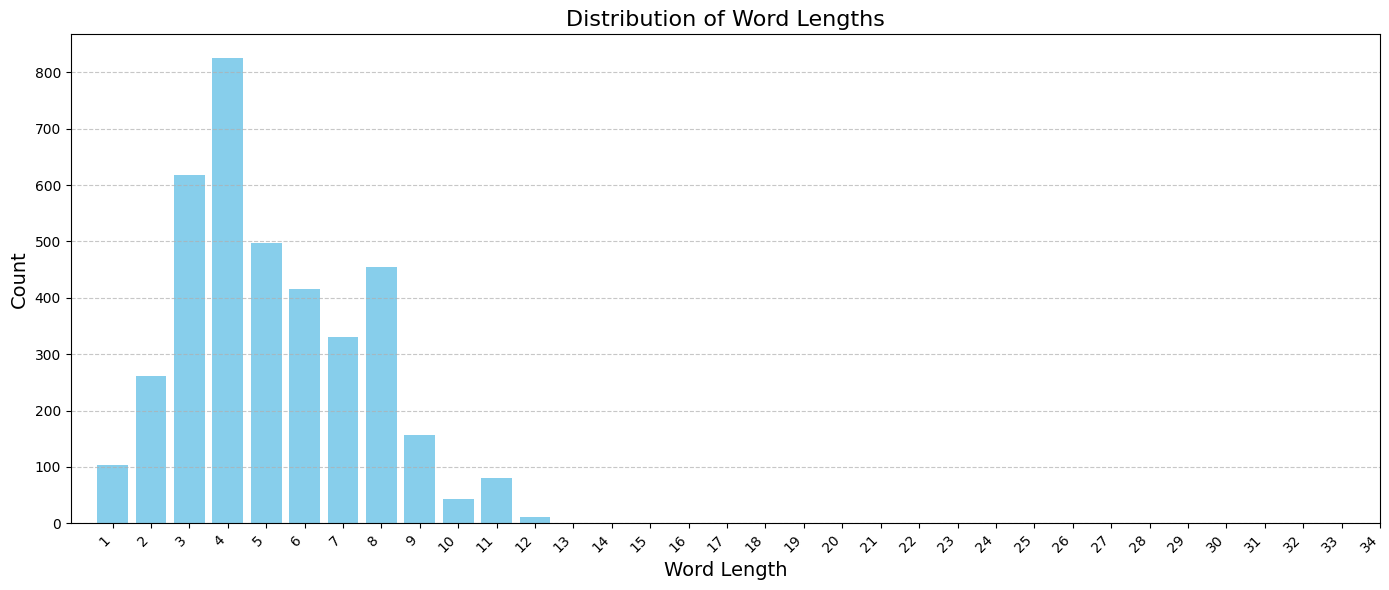

In [ ]:
# !pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jellyfish
from scipy.sparse.csgraph import connected_components
from scipy.spatial.distance import squareform



def clean_text(text):
    # Remove non-alphanumeric characters except spaces
    cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Normalize spaces (replace multiple spaces with a single space)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

model_df = pd.read_csv('test_v2.csv')
question = 'Q5: What movie do you think of when thinking of this food item?'




# filtering manually
forced_spiderman = ['into the spiderverse', 'spiderman just cause it takes place in new york', 'i think of spiderman when thinking of this food item','spider man 2','sam raimis spider man',  'i think of the spiderman movie', 'spiderman', 'spider man', 'spiderman with tobey maguire',  'spiderman 2', 'spiderman 2002 starring tobey maguire']
forced_avengers = ['the avengers', 'i think of the avengers when i think of shawarma',
'i think of the avengers when thinking of this food item', 'i dont usually think of any movie when having this food item but after using google to refresh my memory i would say avengers because of the postcredits scene','i think of the movie the avengers because in the final scene of the movie tony stark takes the avengers to the shawarma place',
'i think about the movie avengers when i think of shawarma','i think of the movie named avengers', 'i think of the movie the avengers','i think of the movie the avengers they have an entire bit surrounding this food item', 'avengers end game', 'avengers 1','avenegers',  'the avengers action movies',
'the avengers postcredit scene', 'avangers','avengers age of ultron', 'avengers age of ultron','marvel avengers', 'marvels avengers','advengers 2012 movie', 'avengers 2012',
 'avenger', 'avenger', 'that one marvel movie i dont know i dont watch movies','not exactly movies but i would prefer to watch some tv series when i am having pizzas if movies specifically i may think of cartoon movies or more heromarvel related ones like teenage mutant ninja turtles movies in marvel series etc',
                   'the avengers because they eat it together after the battle of new york',
                   'the avengers movie when they eat shawarma in the end credits scene','avengers because of iron man asking everyone to get shawarma after the fight',
                   'the only movie that is associated with this food item would be the first avengers due to the post credit scene',
'the avengers at the end of the film after the battle in nyc tony stark suggests to the rest of the team that they go get shawarma'	,
                   'the avengers action movies', 'marvel movies', 'endgame',  'avengers',  'avengers endgame', 'the avengers 2012']
forced_teens = [ 'teenage mutant ninja turtle', 'rise of the teenage mutant ninja turtles the movie 2022',
                'teenage mutant ninja turtles vs batman the tmnt love pizza and they eat it with batman at the end of the movie',
                'i think of the ninja turtle movies when thinking of pizza', 'the teenage mutant ninja turtles', 'ninja turtle','tnmt','ninja turtle',  'ninja turtles', 'teenage mutant ninja turtles',  'any teenage mutant ninja turtle movie', 'inside out teenage mutant ninja turtles']
i_hate_you = [ 'none', 'none ok tbf i think of my life at uoft if life is a movie','no movies come to mind', 'no movie came up to my mind','idk', 'i actually can not think of anything', 'no movie', 'no movie comes to mind', 'not sure', 'none specifically', 'nothing',
 'i dont', 'i cant think of anything', '', 'no movies come to mind',  'i dont know', 'no', 'scific movies', 'no', 'none come to mind', 'no but i think japan', 'i dont think of any movie', 'i dont think of any movie', 'i dont think of a movie', 'i dont watch movies',
 'i dont know', 'none in particular', 'na', 'na i only watched a few movies so i cannot think of any movie related to pizza',
'na i only watched a few movies so i cannot think of any movie related to shawarma', 'i dont have a movie i think of when i think of pizza',
               'ive never had them before attending u of t so i dont associate them with anything',
'na i only watched a few movies so i cannot think of any movie related to sushi',	'none stranger things is the tv series i can think of',
'na i dont watch a lot of movies', 'i dont know that many movies fr','i have no idea i dont eat that stuff',
'na i dont watch a lot of movies', 'i think about the first avengers movie after they fought off the aliens in the city the superheroes gather at a local shawarma place that is nearly destroyed because of the alien invasion and eat quietly around the table',
'na i dont watch a lot of movies', 'i dont have a movie i think of when i think of sushi','i dont think of a movie when thinking of this food item','i dont think of any movie pizza pairs well with any movie',
               'i might think of some short ones or simply videos as when i am having shawarma i do not usually have much time and the food is some hands size so people can usually finish it up quickly so i would say no movieshort ones like monster inc',
               'probably some niche movie or some movie specific to a country and not an english movie',
               'nothing comes to mind', 'no movie that i can think','none specifically']
froced_deadpool=['deadpool', 'deadpool 3', 'deadpool 2','deadpool wolverine is the movie that comes to mind this is because of the ending scene where they get this food after their battle',

                 'deadpool vs wolverine',  'deadpool wolverine']
forced_sponge = [  'spongebob', 'the spongebob movie 2004']
forced_poke=[ 'pokemon the first movie', 'pokemon']
forced_pizza = [ 'pizza', 'pizza 2012', 'honestly any movie pizza is a movie food', 'i think about a nice chill movie with pizza maybe something like hangover']
forced_fnaf = [ 'five nights at freddies', 'five nights at freddys']
forced_iron_man = [ 'iron man', 'iron man i']
froced_home_alon = [ 'i think of home alone', 'for some reason home alone is the first thing that came to mind',
                    'i usually associate this item with the winter because school parties would frequently order this food item hence i would say the polar express elf and home alone',
                    'home alone because kevin orders an entire one for himself','home alone when the delivery guy delivers a cheese pizza little neros pizza through the back door for kevin when he gets stuck home alone',
                     """home alone is the first movie that comes to minds im referring to the scene were the whole family order 10 boxes of pizza and their trying to see who is going to pay""",'i think about about the movie home alone','home alone', 'home alone 2 lost in new york', 'home alone 2 lost in new york','home alone 2', 'home alone or action movies', 'homealone']
f_fnf = [ 'fast and furious', 'fast and furious tokyo drift',  'tokyo drift']
mario=[ 'mario movie', 'the mario movie']
nemo=[ 'findig nemo', 'nemo', 'finding nemo was the first movie in my mind']
your_nae=[ 'your name 2016']
j_W = [ 'john wick 3', 'john wick chapter 4', 'john wick chapter 3 parabellum', 'john wick chapter 3 parabellum']
alessia = [ 'the italian job','italian movie', 'italian jon', 'i think of the movie little italy the entire plot revolves around two individuals who are competing in a restaurant business where their primary product is this food item'] # italian job
mib = [ 'men in black','mib',  'man in black']
misison_impossible=[ 'action movie like mission impossible']
borat=['i think of the movie borat']
wolv = ['the wolverine', 'the wolverine', 'the wolverine', 'the wolverine','wolverine']

jap = ['any japanese movie and animes', 'tokyo story 1953', 'tokyo story', 'a japanese anime movie such as spirited away',
       'some japanese movie or some action movie', 'spirited away or any japanese movie in general',
       'i think of ninja movies with i think of sushi especially japanese anime ninja movies','i dont think of any movies i think of anime',
       'sushi is from japan so i would think about a japanese movie your name the anime movie', 'almost all asian movies especially japanese not any movie in particular comes in mind'

       ]
spiderverse=['into the spiderverse', ]
totoro=['some ghibli movie', ]
lionking=['mufasa the lion king']
harry=['harry potter the philosophers stone', 'i watched the harry potter series with my friends while eating sushi so i associate sushi with harry potter']
bruh = ['something fun like superbad']
sushi=['dreams of sushi', 'i might came up with some japan related movieslike jiro dreams of sushi this is in fact a documentarycartoonslike tv series like the solitary gourmet',
       'i think of the movie jiro dreams of sushi', 'i think of the movie jiro dreams of sushi it is a movie about an 85 year old sushi master behind a three michelin star sushi restaurant and his sons who are set to take over the business']
pasgetti = ['spaghetti with a chance of meatballs', 'i think of the movie cloudy with a chance of meatballs', 'i think of the movie cloudy with a chance of meatballs because i associate pizza with popular italian cuisine and meatballs is italian cuisine']
garfield=['the garfield movie', 'the garfield movie']


print(model_df[question].value_counts())

model_df[question] = model_df[question].astype(str)
model_df[question] = model_df[question].str.lower()
model_df[question] = model_df[question].apply(lambda x: clean_text(str(x)) if pd.notnull(x) else '')

model_df[question] = model_df[question].replace(forced_spiderman, 'spiderman')
model_df[question] = model_df[question].replace(forced_avengers, 'the avengers')
model_df[question] = model_df[question].replace(forced_teens, 'teenage mutant ninja turtles')
model_df[question] = model_df[question].replace(i_hate_you, 'none')
model_df[question] = model_df[question].replace(froced_deadpool, 'deadpool')
model_df[question] = model_df[question].replace(forced_sponge, 'spongebob')
model_df[question] = model_df[question].replace(forced_poke, 'pokemon')
model_df[question] = model_df[question].replace(forced_pizza, 'pizza')
model_df[question] = model_df[question].replace(forced_fnaf, 'five nights at freddys')
model_df[question] = model_df[question].replace(forced_iron_man, 'iron man')
model_df[question] = model_df[question].replace(froced_home_alon, 'home alone')
model_df[question] = model_df[question].replace(f_fnf, 'fast and furious')
model_df[question] = model_df[question].replace(mario, 'mario movie')
model_df[question] = model_df[question].replace(nemo, 'finding nemo')
model_df[question] = model_df[question].replace(j_W, 'john wick')
model_df[question] = model_df[question].replace(alessia, 'the italian job')
model_df[question] = model_df[question].replace(mib, 'men in black')
model_df[question] = model_df[question].replace(misison_impossible, 'mission impossible')
model_df.loc[:, question] = model_df[question].replace('i think of the movie borat', 'borat')
model_df[question] = model_df[question].replace(wolv, 'wolverine')
model_df[question] = model_df[question].replace(jap, 'japanese')
model_df[question] = model_df[question].replace(totoro, 'totoro')
model_df[question] = model_df[question].replace(lionking, 'lion king')
model_df[question] = model_df[question].replace(harry, 'harry potter')
model_df[question] = model_df[question].replace(bruh, 'superbad')
model_df[question] = model_df[question].replace(sushi, 'jiro dreams of sushi')
model_df[question] = model_df[question].replace(pasgetti, 'cloudy with a chance of meatball')
model_df[question] = model_df[question].replace(garfield, 'garfield')



ratatouil=[
    """ it sounds like youre referring to the movie ratatouille its a pixar animated film about a rat named remy who dreams of becoming a great chef despite being a rodent in a profession dominated by humans the story is set in paris and it beautifully blends themes of passion creativity and perseverance in the culinary world let me know if this is the one youre thinking of""",
    'rattatouie even though there isnt pizza','ratatouille again but thats because my knowledge of movies is limited and i barely watch any',
           'ratatouille because the rat is italian and italians like pizza', 'i think about the movie ratatouille as it took place in italy and pizza reminds me of italy',
            'ratatouille because sushi needs to be sliced and they slice food in ratatouille',
            'ratatouille because the rat cooks food and this is food','it sounds like youre referring to the movie ratatouille its a pixar animated film about a rat named remy who dreams of becoming a great chef despite being a rodent in a profession dominated by humans the story is set in paris and it beautifully blends themes of passion creativity and perseverance in the culinary world let me know if this is the one youre thinking of, it sounds like youre referring to the movie ratatouille its a pixar animated film about a rat named remy who dreams of becoming a great chef despite being a rodent in a profession dominated by humans the story is set in paris and it beautifully blends themes of passion creativity and perseverance in the culinary world let me know if this is the one youre thinking of, it sounds like youre referring to the movie ratatouille its a pixar animated film about a rat named remy who dreams of becoming a great chef despite being a rodent in a profession dominated by humans the story is set in paris and it beautifully blends themes of passion creativity and perseverance in the culinary world let me know if this is the one youre thinking of']
ur_name=['i think of the movie your name', 'i think of your name when thinking of this food item',]
mulan=['think of mulan which my family and i watched last weekend while eating shawarma']

bigbigwolf=['i would associate it with movie series like pleasant goat and big big wolf as that was one of the childhood shows i watched from the time when we could sometimes go and eat out as a family']
thebigshort=['the movie that comes to mind for this food item is the big short there is one scene that is very vivid and eyeopening conversations when it comes to the fault of hedge funds during the 2008 crisis that was discussed over this food item']
starwqrs=['star wars episode v the empire strikes back']
scottpilgtam=['i think of movies that take place in toronto since its so common here such as scott pilgrim vs the world']

#	middle east movie
middle_east=['probably something with a middle eastern setting', 'i think of middle easternindian movies but nothing some in mind specifically',
             'probably some middle eat movies', 'those commercials by the toronto food man za bebsi is the best']
legendshawrama=['none only thing i know about it is the game shawarma legend', 'not suremaybe turkish movies but it will remind me of a game called shawarma legend which is a simulation game and highly recommended',
                'cant think of any dont have an idea about the taste of shawarma and havent seen it in any movie that ive watched']
shrekkk=['i think about movies like holes or shrek since it reminds me of the movies teachers would put on for us during school events',
         'when eating pizza i think of the movie shrek 2', 'when eating shawarma i think of the movie shrek 2', 'when eating sushi i think of the movie shrek 2']
chef=['i think of the movie chef2014 as it was very foodrelated and had a lot of ovenbaked goods','i think of the movie named chef',  'we live in time in one of the scenes the chef is making sushi i watched it recently']
food_wars =['i thought of the anime food wars', 'i think of the anime food wars']
jaws=['i think of the movie jaws because sushi is fish and jaws is a movie about shark which is a fish']
cheech_chong=['i think of the cheech chong movies when i think of shawarma']
goodtime=['i think about the movie good time when thinking of this food item']
isledogs = ['isle of dogs this film showcases a chef making a poisoned sushi']
brkfast=['breakfast club one of the characters gets into an argument with someone else if eating sushi is allowed']
brkabad=['i actually think of the series breaking bad and that famous scene where walter flips out']
docs = ['bbc food channels movies and documentaries']

penguinismagdas=['penguins of madagascar there was a scene where all penguins made sushi and had to fight a big purple octopus with it']
cars=['i think of cars 2 when thinking of this food item this is because of the scene where tow mater mistakes wasabi a popular topping for this food item for pistachio ice cream with comical results']
toystory=['toy story the restaurant that the green aliens come from serve it the name of the restaurant is an alliteration with the last word of the name being planet']
malena=['when thinking of pizza it would reminder me of italy and the first movie that came to mind was malena']
minions=['to be honest i cant really think of any movie but if i have to answer i would say minions rise of gru']
gilmore_girls=['i think of the show gilmore girls theyre always eating pizza']
goodfellas=['goodfellas there is a restaurant that sells pizza and is goodfellas themed']
cartoons=['im thinking of cartoons and mostly western based cartoon though i cant think of anything specific but mostly western cartoon movies']
godfather=['i think of italian mobster movies like the godfather']

bruhh=['it sounds like youre referring to the movie ratatouille its a pixar animated film about a rat named remy who dreams of becoming a great chef despite being a rodent in a profession dominated by humans the story is set in paris and it beautifully blends themes of passion creativity and perseverance in the culinary world let me know if this is the one youre thinking of']

model_df[question] = model_df[question].replace(bruhh, 'ratatouille')
model_df[question] = model_df[question].replace(ratatouil, 'ratatouille')
model_df[question] = model_df[question].replace(ur_name, 'your name')
model_df[question] = model_df[question].replace(mulan, 'mulan')
model_df[question] = model_df[question].replace(bigbigwolf, 'big big wolf')
model_df[question] = model_df[question].replace(thebigshort, 'the big short')
model_df[question] = model_df[question].replace(starwqrs, 'star wars')
model_df[question] = model_df[question].replace(scottpilgtam, 'scott pilgrim vs the world')
model_df[question] = model_df[question].replace(middle_east, 'middle east movie')
model_df[question] = model_df[question].replace(legendshawrama, 'shawarma legend')
model_df[question] = model_df[question].replace(shrekkk, 'shrek')
model_df[question] = model_df[question].replace(chef, 'chef')
model_df[question] = model_df[question].replace(food_wars, 'food wars')
model_df[question] = model_df[question].replace(jaws, 'jaws')
model_df[question] = model_df[question].replace(cheech_chong, 'cheech chong')
model_df[question] = model_df[question].replace(goodtime, 'good time')
model_df[question] = model_df[question].replace(isledogs, 'isle of dogs')
model_df[question] = model_df[question].replace(brkfast, 'breakfast club')
model_df[question] = model_df[question].replace(brkabad, 'breaking bad')
model_df[question] = model_df[question].replace(docs, 'documentary')
model_df[question] = model_df[question].replace(penguinismagdas, 'pengnuins of madagascar')
model_df[question] = model_df[question].replace(cars, 'cars')
model_df[question] = model_df[question].replace(toystory, 'toy story')
model_df[question] = model_df[question].replace(malena, 'malena')
model_df[question] = model_df[question].replace(minions, 'minions')
model_df[question] = model_df[question].replace(gilmore_girls, 'gilmore girls')
model_df[question] = model_df[question].replace(goodfellas, 'goodfellas')
model_df[question] = model_df[question].replace(cartoons, 'cartoons')
model_df[question] = model_df[question].replace(godfather, 'the godfather')





print(model_df[question].value_counts())

q5 = model_df[['id', question]]

q5[question] = q5[question].str.lower()
q5[question] = q5[question].astype(str)
q5['word_count'] = q5[question].str.split().str.len()
q5 = q5.sort_values(by='word_count', ascending=False)  # Use ascending=True for increasing order


# divide based on median, so we divide the yapping rants vs actual titles (assuming its likely chances)
# actually, not very satisfied with this median length....
word_lengths = q5[question].str.split().explode().str.len()
median_word_length = word_lengths.quantile(0.5)
print(median_word_length)

# ... we did more exploration
# Compute the median word length across the entire column
median_word_length = word_lengths.quantile(0.95)
print(median_word_length)

# Count the occurrences of each word length
word_length_counts = word_lengths.value_counts().sort_index()

# Plot the counts for each word length
plt.figure(figsize=(14, 6))  # Increase figure width to provide more space
bars = plt.bar(word_length_counts.index, word_length_counts.values, color='skyblue')
plt.title("Distribution of Word Lengths", fontsize=16)
plt.xlabel("Word Length", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(range(1, 35), rotation=45, ha='right', fontsize=10)  # Rotate labels and align them to the right
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

# Export the DataFrame to a CSV file
# analyzing this shows us that from 6-7 words is split between real movie
# names and long answers. Will use the cut-off of 6<= words for the first part
# of processing and >6 that has additional processing
q5.to_csv('/content/word_counted_responses.csv', index=False)




In [ ]:
# """
# Now let's start classifying based on the data set:
# """

# Extract the 'id' column and the responses
ids = q5[q5['word_count'] < 7]['id']  # Store the 'id' column
responses = q5[q5['word_count'] < 7][question]  # Extract only the responses

# Reset the index of the responses Series
responses = responses.reset_index(drop=True)  # Reset index to 0, 1, 2, ...
responses = responses.apply(clean_text)


# Function to compute the similarity matrix
def compute_similarity_matrix(responses, similarity_func, threshold):
    n = len(responses)
    similarity_matrix = np.zeros((n, n))

    # Vectorized computation of pairwise similarities
    for i in range(n):
        for j in range(i+1, n):  # Only compute upper triangle
            similarity = similarity_func(responses[i], responses[j])
            if similarity >= threshold:
                similarity_matrix[i, j] = 1
                similarity_matrix[j, i] = 1  # Symmetric

    return similarity_matrix

# Compute the similarity matrix using Jaro-Winkler similarity
threshold = 0.87
similarity_matrix = compute_similarity_matrix(
    responses, jellyfish.jaro_winkler_similarity, threshold
)

# Identify clusters using connected components
n_components, labels = connected_components(csgraph=similarity_matrix, directed=False)

# Group responses and their corresponding IDs based on clusters
clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = {'responses': [], 'ids': []}
    clusters[label]['responses'].append(responses[i])  # Store the response
    clusters[label]['ids'].append(ids.iloc[i])  # Store the corresponding ID

############## for analysis ################

# Output clusters
for cluster_id, group in clusters.items():
    print(f"Group {cluster_id}: Responses: {group['responses']}, IDs: {group['ids']}")

# Convert clusters into a DataFrame
cluster_data = []
for cluster_id, group in clusters.items():
    cluster_data.append({
        'Cluster ID': cluster_id,
        'Responses': ', '.join(group['responses']),  # Combine responses into a single string
        'IDs': ', '.join(map(str, group['ids'])),  # Combine IDs into a single string
        'Number of Responses': len(group['responses'])  # Add count of responses in the cluster
    })

# Create the DataFrame
clusters_df = pd.DataFrame(cluster_data)
clusters_df = clusters_df.sort_values(by='Number of Responses', ascending=False)

# Save the DataFrame to a CSV file
clusters_df.to_csv('workin_smaller_class.csv', index=False)

Group 0: Responses: ['you dont mess with the zohan', 'you dont mess with the zohan'], IDs: [np.int64(608318), np.int64(628102)]
Group 1: Responses: ['cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatball', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatball', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatball', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cloudy with a chance of meatballs', 'cl

In [ ]:


# Output the DataFrame
print(clusters_df)
df_i = clusters_df

"""
# List of IDs to merge
ids_to_merge = [268, 23 271  98 290  14   ]


ids_to_merge_avengers = [66, 72, 158, ]
turtles = [  223,            ]

df_i = clusters_df

# Filter rows with the specified IDs
filtered_df = df_i[df_i['Cluster ID'].isin(ids_to_merge)]

print(filtered_df)

# Ensure 'Responses' and 'IDs' are lists (handle cases where they are strings)
def ensure_list(value):
    if isinstance(value, str):  # If it's a string, split it into a list
        return value.split(', ')
    return value  # Otherwise, assume it's already a list


# Aggregate the data
merged_row = {
    'Cluster ID': ids_to_merge[0],  # Use the first ID as the label
    'Responses': sum(filtered_df['Responses'].apply(ensure_list).tolist(), []),  # Concatenate lists of responses
    'IDs': sum(filtered_df['IDs'].apply(ensure_list).tolist(), []),  # Concatenate lists of IDs
    'Number of Responses': filtered_df['Number of Responses'].sum(),  # Sum the count
}

# Create a new DataFrame for the merged row
merged_df = pd.DataFrame([merged_row])

# Remove the merged rows from the original DataFrame
df_i = df_i[~df_i['Cluster ID'].isin(ids_to_merge)]
"""

def ensure_list(value):
    if isinstance(value, str):  # If it's a string, split it into a list
        return value.split(', ')
    return value  # Otherwise, assume it's already a list


# Function to find the median-length string in a list
def find_median_length_string(string_list):
    if not string_list:  # Handle empty lists
        return None
    # Sort the list by string length
    sorted_list = sorted(string_list, key=lambda x: len(x))
    # Find the median index
    median_index = len(sorted_list) // 2
    return sorted_list[median_index]  # Return the entire string

# Apply the function to the 'Responses' column to create the 'Label' column
df_i['Label'] = df_i['Responses'].apply(ensure_list).apply(find_median_length_string)
df_i.to_csv('/content/clusters_output_v2.csv', index=False)


# Iterate through each row in all_res_mapping
for index, row in df_i.iterrows():
    ids = row['IDs']  # Get the list of IDs for this group
    label = row['Label']  # Get the label for this group

    # Iterate through each ID in the list
    for id in ids:
        # Find the row in qq where the 'id' column matches the current ID
        match_index = model_df[model_df['id'] == id].index

        # If a match is found, replace the 'question' column with the label
        if not match_index.empty:
            model_df.loc[match_index, question] = label

model_df = model_df.fillna('none')

import pandas as pd
import copy
import ast

stopwords = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has',
    'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
    'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
    'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now',
    'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',
    "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
    "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
    'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
]


# Function to remove stopwords from a text
def remove_stopwords(text):
    words = text.split()  # Split the text into words
    filtered_words = [word for word in words if word.lower() not in stopwords]  # Remove stopwords
    return ' '.join(filtered_words)  # Join the words back into a sentence

# long_words_bombo = q5[q5['word_count'] > 6][question].to_list()
# model_df[question] = model_df[question].apply(lambda x: remove_stopwords(x) if str(x) in long_words_bombo else x)

# part 2 beware same variable names
ids = model_df['id']  # Store the 'id' column
responses = model_df[question]  # Extract only the responses
responses = responses.reset_index(drop=True)  # Reset index to 0, 1, 2, ...

similarity_matrix = compute_similarity_matrix(
    responses, jellyfish.jaro_winkler_similarity, threshold
)

# Identify clusters using connected components
n_components, labels = connected_components(csgraph=similarity_matrix, directed=False)

# Group responses and their corresponding IDs based on clusters
clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = {'responses': [], 'ids': []}
    clusters[label]['responses'].append(responses[i])  # Store the response
    clusters[label]['ids'].append(ids.iloc[i])  # Store the corresponding ID

############## for analysis ################

# Output clusters
for cluster_id, group in clusters.items():
    print(f"Group {cluster_id}: Responses: {group['responses']}, IDs: {group['ids']}")

# Convert clusters into a DataFrame
cluster_data = []
for cluster_id, group in clusters.items():
    cluster_data.append({
        'Cluster ID': cluster_id,
        'Responses': ', '.join(group['responses']),  # Combine responses into a single string
        'IDs': ', '.join(map(str, group['ids'])),  # Combine IDs into a single string
        'Number of Responses': len(group['responses'])  # Add count of responses in the cluster
    })

# Create the DataFrame
clusters_df = pd.DataFrame(cluster_data)
clusters_df = clusters_df.sort_values(by='Number of Responses', ascending=False)

# Save the DataFrame to a CSV file
clusters_df.to_csv('BIG_FAT_CLUSTERS.csv', index=False)

df_i=clusters_df
df_i['Label'] = df_i['Responses'].apply(ensure_list).apply(find_median_length_string)

# Iterate through each row in all_res_mapping
for index, row in df_i.iterrows():
    ids = row['IDs']  # Get the list of IDs for this group
    label = row['Label']  # Get the label for this group

    # Iterate through each ID in the list
    for id in ids:
        # Find the row in qq where the 'id' column matches the current ID
        match_index = model_df[model_df['id'] == id].index

        # If a match is found, replace the 'question' column with the label
        if not match_index.empty:
            model_df.loc[match_index, question] = label

model_df = model_df.fillna('none')



# # Save the updated qq DataFrame to a CSV file (optional)
model_df.to_csv('/content/please_be_done.csv', index=False)




     Cluster ID                                          Responses  \
26           26  the avengers, the avengers, the avengers, the ...   
4             4  none, none, none, none, none, none, none, none...   
16           16  teenage mutant ninja turtles, teenage mutant n...   
7             7  home alone, home alone, home alone, home alone...   
9             9  spiderman, spiderman, spiderman no way home, s...   
..          ...                                                ...   
328         328                                          good time   
327         327                                      pearl harbour   
326         326                                    ultraman rising   
325         325                                       the meg 2018   
339         339                             kikis delivery service   

                                                   IDs  Number of Responses  
26   715814, 625326, 728522, 633234, 712093, 840827...                  258  
4  